# Experts that use simulate
In this notebook we'll analyze the behaviour of experts that use the `simulate` functionality in the observations to choose actions.

In [1]:
from grid2op.Agent import BaseAgent
from grid2op.Converter.IdToAct import IdToAct

from grid2op.multi_agent.ma_typing import LocalObservation, LocalObservationSpace, \
    LocalAction, LocalActionSpace 

from grid2op import make
from grid2op.Action.PlayableAction import PlayableAction
from grid2op.Action import BaseAction
from grid2op.multi_agent.multiAgentEnv import MultiAgentEnv
import numpy as np
from grid2op.multi_agent.multi_agentExceptions import *

    
import numpy as np

from lightsim2grid import LightSimBackend
bk_cls = LightSimBackend

action_domains = {
    'agent_0' : [0,1,2,3, 4],
    'agent_1' : [5,6,7,8,9,10,11,12,13]
}
env_name = "l2rpn_case14_sandbox"#"educ_case14_storage"
env = make(env_name, test=False, backend = bk_cls(),
                action_class=PlayableAction, _add_to_name="_test_ma")


ma_env = MultiAgentEnv(env, action_domains, copy_env=False)

ma_env.seed(0)
obs = ma_env.reset()
        

/home/najarfar/Internship/Grid2Op/grid2op/multi_agent/multiAgentEnv.py:123: UserWarning: Rules can not be changed in this version.
  warnings.warn("Rules can not be changed in this version.")
/home/najarfar/Internship/Grid2Op/grid2op/multi_agent/multiAgentEnv.py:129: UserWarning: The central env has been heavily modified (parameters and reset) !
  warnings.warn("The central env has been heavily modified (parameters and reset) !")


In [2]:

from typing import Dict
from grid2op.multi_agent.ma_typing import MAAgents
from grid2op.Environment.BaseEnv import BaseEnv
from grid2op.Agent.baseAgent import BaseAgent
from grid2op.multi_agent.multiAgentEnv import MultiAgentEnv


def _run_simple_actor(
    env : BaseEnv,
    actor : BaseAgent,
    nb_episodes : int,
    save_path : str
) -> dict:
    
    T = np.zeros(nb_episodes, dtype = int)
    obs = env.reset()
    t = 0
    
    print("Running simple simulation !")
    from tqdm.notebook import tqdm
    
    rewards_history = [[] for _ in range(nb_episodes)]
    mean_rewards_history = np.zeros(nb_episodes)
    std_rewards_history = np.zeros(nb_episodes)
    cumulative_reward = np.zeros(nb_episodes)
    
    info_history = [[] for _ in range(nb_episodes)]
    
    obs_history = [[] for _ in range(nb_episodes)]
    obs_history[0].append(obs.to_vect())
    
    done_history = [[] for _ in range(nb_episodes)]
    
    actions_history = [[] for _ in range(nb_episodes)]
    
    reward = 0
    
    for episode in tqdm(range(nb_episodes)):
        
        while True:
            t += 1
            obs_history[episode].append(obs.to_vect())
            
            action = actor.act(observation = obs, reward = reward)
            obs, reward, done, info = env.step(action)
            
            #obs._obs_env = None
            rewards_history[episode].append(reward)
            info_history[episode].append(info.copy())
            done_history[episode].append(done)
            actions_history[episode].append(action.copy())

            if done:
                #mean_rewards_history[episode] = np.mean(rewards_history)
                #std_rewards_history[episode] = np.std(rewards_history)
                cumulative_reward[episode] = np.sum(rewards_history[episode])
                obs = env.reset()
                T[episode] = t
                t = 0
                
                break
        if (episode+1)%10==0:
            np.save(save_path+'/'+f'single_cum_rewards{episode}.npy', arr=cumulative_reward)
            np.save(save_path+'/'+f'single_T{episode}.npy', arr=T)
            
    return {
        'rewards' : rewards_history,
        #'mean_rewards' : mean_rewards_history,
        #'std_rewards' : std_rewards_history,
        'episode_len' : T,
        'info_history' : info_history,
        'observations' : obs_history,
        'done_history' : done_history,
        'actions' : actions_history,
        'cumulative_reward' : cumulative_reward
    }

def _run_ma_actors(
    ma_env : MultiAgentEnv,
    actors : MAAgents,
    nb_episodes : int,
    save_path : str
) -> dict:
    
    print("Running multi-agent simulation !")
    
    T = np.zeros(nb_episodes, dtype = int)
    obs = ma_env.reset()
    t = 0
    
    from tqdm.notebook import tqdm
    
    rewards_history = [[] for _ in range(nb_episodes)]
    mean_rewards_history = np.zeros(nb_episodes)
    std_rewards_history = np.zeros(nb_episodes)
    cumulative_reward = np.zeros(nb_episodes)
    
    info_history = [[] for _ in range(nb_episodes)]
    
    local_actions = [[] for _ in range(nb_episodes)]
    
    done_history = [[] for _ in range(nb_episodes)]
    
    actions_history = [[] for _ in range(nb_episodes)]
    
    obs_history = [[] for _ in range(nb_episodes)]
    
    r = 0
    
    for episode in tqdm(range(nb_episodes)):
        while True:
            t += 1
            
            obs_history[episode].append(obs[ma_env.agents[0]].to_vect())
            
            actions = {
                agent : actors[agent].act(observation = obs[agent], reward = r)
                for agent in ma_env.agents
            }
            obs, reward, dones, info = ma_env.step(actions)

            r = reward[ma_env.agents[0]]
            rewards_history[episode].append(r)
            info_history[episode].append(info[ma_env.agents[0]].copy())
            
            #for agent in ma_env.agents:
            #    # TODO pourquoi ce problème ?
            #    obs[agent]._obs_env = None
                
            local_actions[episode].append(actions.copy())
            done_history[episode].append(dones[ma_env.agents[0]])
            actions_history[episode].append(ma_env.global_action.copy())
                

            if dones[ma_env.agents[0]]:
                #mean_rewards_history[episode] = np.mean(rewards_history)
                #std_rewards_history[episode] =  np.std(rewards_history)
                cumulative_reward[episode] = np.sum(rewards_history[episode])
                
                obs = ma_env.reset()
                T[episode] = t
                t = 0
                break
        if (episode+1)%10 == 0 and episode>0:
            np.save(save_path+'/'+f'cum_rewards{episode}.npy', arr=cumulative_reward)
            np.save(save_path+'/'+f'T{episode}.npy', arr=T)
            np.save(save_path+'/'+f'observations{episode}.npy', arr=obs_history)
            np.save(save_path+'/'+f'local_actions{episode}.npy', arr=local_actions)
            
            
    return {
        'rewards' : rewards_history,
        #'mean_rewards' : mean_rewards_history,
        #'std_rewards' : std_rewards_history,
        'observations' : obs_history,
        'episode_len' : T,
        'info_history' : info_history,
        'local_actions' : local_actions,
        'done_history' : done_history,
        'actions' : actions_history,
        'cumulative_reward' : cumulative_reward
    }

    
def compare_simple_and_multi(
    ma_env, # It is grid2op.multi_agent.multiAgentEnv.MultiAgentEnv
    simple_actor : BaseAgent, 
    ma_actors : MAAgents, 
    episodes : int = 2,
    seed = 0,
    chronics_id = 0,
    save_path = "./",
    ):
    
    ma_env.seed(seed)
    ma_env._cent_env.set_id(chronics_id)
    
    results_simple = _run_simple_actor(ma_env._cent_env, simple_actor, episodes, save_path)
    np.save(save_path+'/'+f'results_simple{episodes}.npy', arr=results_simple)
    
    
    ma_env.seed(seed)
    ma_env._cent_env.set_id(chronics_id)
    results_ma = _run_ma_actors(ma_env, ma_actors, episodes, save_path)
    np.save(save_path+'/'+f'results_ma{episodes}.npy', arr=results_ma)
    
    #save results
    # TODO
    
    return results_simple, results_ma

### Predictors
Here we define predictors than given an observation (local or global), it predicts the coworker's action.

In [3]:
class Predictor:
    def __init__(self, 
                 action_space,
                 do_nothing = False,
                 model = None,
                 nn_kwargs = {}):
        
        self.action_space = action_space
        self.do_nothing = do_nothing
        self.model = model
        
        res = [self.action_space({})]  # add the do nothing
        res += self.action_space.get_all_unitary_topologies_set(self.action_space)
        self.all_actions = res
        
    
    def predict(self, observation : LocalObservation) -> LocalAction:
        if self.do_nothing:
            return self.action_space({})
        elif self.model is not None:
            #TODO return the prediction
            a = self.model.predict([observation.to_vect()])[0]
            return self.all_actions[a]
        else:
            raise("Model is missing !")
            

### Local greedy expert with topological actions only
Here, local experts aim to find the best topological action using the simulate 

In [4]:
from typing import List, Optional
import copy

class LocalTopologyGreedyExpert(BaseAgent):
    def __init__(self,
                 agent_nm,
                 action_space,
                 ma_env,
                 predictors : Optional[List[Predictor]] = None,
                 **kwargs):
        super().__init__(action_space)
        
        self.agent_nm = agent_nm
        self.other_agents = [
            agent
            for agent in ma_env.agents if agent != agent_nm
        ]
        self.executed_actions = set()
        
        self.action_space = action_space
        
        self.curr_iter = 0
        self.ma_env = ma_env
        
        self.global_action_space = ma_env._cent_env.action_space
        
        if predictors is None:
            self.predictors = {
                agent : Predictor(ma_env.action_spaces[agent], do_nothing=True)
                for agent in self.other_agents
            }
        else:
            self.predictors = predictors
            
        self.tested_action = None
            
    def act(self, observation : LocalObservation, reward, done = False):
        self.curr_iter += 1

        # Look for overloads and rank them
        #ltc_list = self.getRankedOverloads(observation)
        #counterTestedOverloads = 0
        #overloaded = np.any(observation.rho >= 1)
        #
        #if not overloaded:
        #    return self.action_space({})
        #else:
        other_actions = {
            agent : self.predictors[agent].predict(observation)
            for agent in self.other_agents
        }
        
        self.tested_action = self._get_tested_action(observation)
        if len(self.tested_action) > 1:
            self.resulting_rewards = np.full(
                shape=len(self.tested_action), fill_value=-np.infty, dtype=float
            )
            for i, action in enumerate(self.tested_action):
                actions = copy.deepcopy(other_actions)
                actions.update({self.agent_nm : action})
                a = action.to_global(self.ma_env._cent_env.action_space)
                is_legal, reason = self.ma_env._cent_env._game_rules(action=a, env=self.ma_env._cent_env)
                if is_legal:
                    (
                        simul_obs,
                        simul_reward,
                        simul_has_error,
                        simul_info,
                    ) = observation.simulate(actions)
                    self.resulting_rewards[i] = simul_reward
                else:
                    self.resulting_rewards[i] = -np.infty

            reward_idx = int(
                np.argmax(self.resulting_rewards)
            )
            
            best_action = self.tested_action[reward_idx]
        else:
            best_action = self.tested_action[0]
            
        return best_action
        
    def _get_tested_action(self, observation):
        if self.tested_action is None:
            res = [self.action_space({})]  # add the do nothing
            # better use "get_all_unitary_topologies_set" and not "get_all_unitary_topologies_change"
            # maybe "change" are still "bugged" (in the sens they don't count all topologies exactly once)
            res += self.action_space.get_all_unitary_topologies_set(self.action_space)
            self.tested_action = res
        return self.tested_action
            
    def reset(self, observation):
        # No internal states to reset
        pass

    def load(self, path):
        # Nothing to load
        pass

    def save(self, path):
        # Nothing to save
        pass

### Assuming others do nothing
In this section, each agent assumes that other agents don't act on the grid. Hence, it has to do the best it can.

In [6]:

from grid2op.Agent import TopologyGreedy, DoNothingAgent

simple_actor = DoNothingAgent(env.action_space)
episodes = 50
ma_actors = dict()
for agent_nm in ma_env.agents:
    ma_actors[agent_nm] = LocalTopologyGreedyExpert(
        agent_nm,
        ma_env.action_spaces[agent_nm],
        ma_env
    )


results_simple, results_ma = compare_simple_and_multi(
    ma_env,
    simple_actor=simple_actor,
    ma_actors=ma_actors,
    episodes=episodes,
    save_path=f'./results{episodes}'
    # TODO plus d'episodes
)

Running simple simulation !


  0%|          | 0/50 [00:00<?, ?it/s]

Running multi-agent simulation !


  0%|          | 0/50 [00:00<?, ?it/s]

/home/najarfar/anaconda3/envs/grid2op/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
/home/najarfar/anaconda3/envs/grid2op/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
/home/najarfar/anaconda3/envs/grid2op/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

: 

: 

In [19]:
for episode in range(episodes):
    assert (results_simple['observations'][episode][0] == results_ma['observations'][episode][0]).all()

In [2]:
np.save('results_ma_l2rpn100.npy', arr=results_ma)
np.save('results_do_nothing_l2rpn100.npy', arr=results_simple)

NameError: name 'np' is not defined

In [3]:
results_ma['cumulative_rewards']

NameError: name 'results_ma' is not defined

In [21]:
res = np.load('results_ma_l2rpn.npy', allow_pickle=True)[None][0]

In [22]:
episodes = len(res['info_history'])

is_illegal_ma = [[] for _ in range(episodes)]

reason_illegal_ma = [[] for _ in range(episodes)]

for episode in range(episodes):
    for info in res['info_history'][episode]:
        is_illegal_ma[episode].append(info['action_is_illegal'])
        if is_illegal_ma[episode][-1]:
            reason_illegal_ma[episode].append(info['reason_illegal'])
print(np.concatenate(is_illegal_ma).sum())#np.concatenate(res['local_actions'])[np.concatenate(is_illegal_ma)][1]['agent_1'])

0


In [ ]:
ma_env.seed(0)
ma_env._cent_env.set_id(0)
simple_actor = TopologyGreedy(ma_env._cent_env.action_space)

results_simple1 = _run_simple_actor(ma_env._cent_env, simple_actor, 100)
np.save("results_simple_l2rpn100.npy", arr=results_simple1)

Running simple simulation !


  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
from grid2op.Agent.fromActionsListAgent import FromActionsListAgent

one_agent_replays = []
replays = []
for episode in range(episodes):
    # Faire plusieurs replay sur plusieurs episodes
    replays.append(
        FromActionsListAgent(
            env.action_space,
            results_ma['actions'][episode]
        )
    )
    
    one_agent_replays.append(
        FromActionsListAgent(
            env.action_space,
            results_simple['actions'][episode]
        )
    )

In [ ]:
print(results_ma['cumulative_reward'] - results_simple['cumulative_reward'])

In [ ]:
illegal_hist = [results_ma['info_history'][0][i]["is_illegal"] for i in range(len(results_ma['info_history']))]
np.where(illegal_hist)

In [ ]:
print(results_ma['episode_len'][0])

In [ ]:
for a in results_ma['actions'][0]:
    print(a)

In [ ]:
box_names = ['simple', 'ma']

plt.boxplot([results_simple['cumulative_reward'], results_ma['cumulative_reward']])
plt.xticks([1, 2], box_names)

In [ ]:
box_names = ['simple', 'ma']

plt.boxplot([results_simple['episode_len'], results_ma['episode_len']])
plt.xticks([1, 2], box_names)

In [ ]:
from grid2op.Agent import DoNothingAgent
env = ma_env._cent_env
env.seed(0)
env.set_id(0)

results_do_nothing = _run_simple_actor(env, actor=DoNothingAgent(env.action_space), nb_episodes=episodes)
rs_donothing = np.mean(results_do_nothing['rewards'], axis=0)

In [ ]:
rs_ma = []
rs_simple = []
for episode in range(episodes):
    rs_ma += list(results_ma['rewards'][episode])
    rs_simple += list(results_simple['rewards'][episode])

In [ ]:
rs_ma = np.array(rs_ma)#np.load('rewards_ma_educ_storage2.npy')
rs_simple = np.array(rs_simple)#np.load('rewards_simple_educ_storage2.npy')
import matplotlib.pyplot as plt
plt.figure(figsize = (21,13))
#rs_ma = np.mean(rs_ma, axis=0)
#rs_simple = np.mean(rs_simple, axis=0)
#rs_ma = rs_ma.flatten()
#rs_simple = rs_simple.flatten()
plt.plot(rs_ma, label='ma')
plt.plot(rs_simple, label='simple')
#plt.plot(rs_donothing, label='do nothing')
plt.legend()

In [ ]:
plt.figure(figsize = (21,13))
plt.plot(np.cumsum(rs_ma) - np.cumsum(rs_simple), label='ma - simple')
plt.hlines(y=0, xmin=0, xmax=len(rs_ma), colors='red', label='0')
#plt.plot(rs_donothing, label='do nothing')
plt.legend()

In [ ]:
env = make(env_name, test=True, backend = bk_cls(),
                action_class=PlayableAction, _add_to_name="_test_ma")


ma_env = MultiAgentEnv(env, action_domains, copy_env=False)

#env = ma_env._cent_env 
ma_env.seed(0)
ma_env._cent_env.set_id(0)
obs = ma_env.reset()
i = 0
rewards = []

#from grid2op.PlotGrid import PlotMatplot
#plot_helper = PlotMatplot(env.observation_space)
#_ = plot_helper.plot_obs(obs['agent_0'])

while True:
    action = results_ma['actions'][0][i]
    i += 1
    new_obs, reward, done, info = ma_env._cent_env.step(action)
    rewards.append(reward)
    if done :
        plt.plot(rewards, label = 'replay')
        plt.plot(results_ma['rewards'][0], label = 'ma')
        plt.legend()
        plt.show()
        plt.plot(np.array(rewards) - np.array(results_ma['rewards'][0]))
        assert (np.array(rewards) - np.array(results_ma['rewards'][0]) == 0).all()
        #_ = plot_helper.plot_obs(obs)
        break
    obs = new_obs

In [ ]:
action = results_ma['actions'][0][i]
print(action)
i+=1
obs, reward, done, info = env.step(action)
_ = plot_helper.plot_obs(obs)

In [52]:
from grid2op.Runner import Runner
import os 
import shutil
from tqdm.notebook import tqdm

env = ma_env._cent_env 

path_agents = "study_agent_getting_started"
max_iter = 10_000

shutil.rmtree(os.path.abspath(path_agents), ignore_errors=True)
if not os.path.exists(path_agents):
    os.mkdir(path_agents)

# make a runner for this agent
path_agent = os.path.join(path_agents, "ReplayAgent")
shutil.rmtree(os.path.abspath(path_agent), ignore_errors=True)

env.seed(0)
env.set_id(0)

replay_cum_rewards = []

for i, replay in enumerate(replays):

    runner = Runner(**env.get_params_for_runner(),
                    agentClass=None,
                    agentInstance=replay
                    )
    res = runner.run(path_save=path_agent,
                     nb_episode=1, 
                     max_iter=max_iter,
                     env_seeds=[0],
                     episode_id=[i],
                     pbar=tqdm)
    print("The results for the evaluated agent are:")
    for _, chron_id, cum_reward, nb_time_step, max_ts in res:
        replay_cum_rewards.append(cum_reward)
        msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
        msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
        msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
        print(msg_tmp)

episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4934.723633
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-13
		 - cumulative reward: 4915.105957
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-14
		 - cumulative reward: 3727.450439
		 - number of time steps completed: 231 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-15
		 - cumulative reward: 4600.995117
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-16
		 - cumulative reward: 2430.205811
		 - number of time steps completed: 147 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-17
		 - cumulative reward: 1808.123657
		 - number of time steps completed: 109 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-18
		 - cumulative reward: 1475.211914
		 - number of time steps completed: 93 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4934.723633
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-13
		 - cumulative reward: 4915.105957
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-14
		 - cumulative reward: 3727.450439
		 - number of time steps completed: 231 / 288


In [53]:
env = ma_env._cent_env 

path_agents = "study_agent_getting_started"
max_iter = 10_000

shutil.rmtree(os.path.abspath(path_agents), ignore_errors=True)
if not os.path.exists(path_agents):
    os.mkdir(path_agents)

# make a runner for this agent
path_agent = os.path.join(path_agents, "ReplayAgent")
shutil.rmtree(os.path.abspath(path_agent), ignore_errors=True)

env.seed(0)
env.set_id(0)

replay_simple_cum_rewards = []

for i, replay in enumerate(one_agent_replays):

    runner = Runner(**env.get_params_for_runner(),
                    agentClass=None,
                    agentInstance=replay
                    )
    res = runner.run(path_save=path_agent,
                     nb_episode=1, 
                     max_iter=max_iter,
                     env_seeds=[0],
                     episode_id=[i],
                     pbar=tqdm)
    print("The results for the evaluated agent are:")
    for _, chron_id, cum_reward, nb_time_step, max_ts in res:
        replay_simple_cum_rewards.append(cum_reward)
        msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
        msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
        msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
        print(msg_tmp)

episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4934.622070
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-13
		 - cumulative reward: 4914.632812
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-14
		 - cumulative reward: 3719.424561
		 - number of time steps completed: 230 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-15
		 - cumulative reward: 4600.714355
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-16
		 - cumulative reward: 3964.305908
		 - number of time steps completed: 241 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-17
		 - cumulative reward: 1807.971436
		 - number of time steps completed: 109 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-18
		 - cumulative reward: 1474.747925
		 - number of time steps completed: 93 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4934.622070
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-13
		 - cumulative reward: 4914.632812
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-14
		 - cumulative reward: 3719.424561
		 - number of time steps completed: 230 / 288


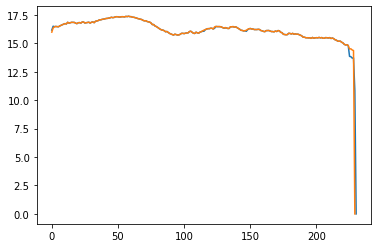

In [64]:
plt.plot(results_ma['rewards'][9])
plt.plot(results_simple['rewards'][9])

In [96]:
from grid2op.Agent import DoNothingAgent
env = ma_env._cent_env 

path_agents = "study_agent_getting_started"
max_iter = 10_000

shutil.rmtree(os.path.abspath(path_agents), ignore_errors=True)
if not os.path.exists(path_agents):
    os.mkdir(path_agents)

# make a runner for this agent
path_agent = os.path.join(path_agents, "ReplayAgent")
shutil.rmtree(os.path.abspath(path_agent), ignore_errors=True)

env.seed(0)
env.set_id(0)

replay_simple_cum_rewards = []

for i, replay in enumerate(one_agent_replays):

    runner = Runner(**env.get_params_for_runner(),
                    agentClass=DoNothingAgent,
                    )
    res = runner.run(path_save=path_agent,
                     nb_episode=1, 
                     max_iter=max_iter,
                     env_seeds=[0],
                     episode_id=[i],
                     pbar=tqdm)
    print("The results for the evaluated agent are:")
    for _, chron_id, cum_reward, nb_time_step, max_ts in res:
        replay_simple_cum_rewards.append(cum_reward)
        msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
        msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
        msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
        print(msg_tmp)

episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4688.167480
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-13
		 - cumulative reward: 4685.237305
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-14
		 - cumulative reward: 3344.289551
		 - number of time steps completed: 220 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-15
		 - cumulative reward: 1388.156250
		 - number of time steps completed: 90 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-16
		 - cumulative reward: 3623.987061
		 - number of time steps completed: 236 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-17
		 - cumulative reward: 3546.453125
		 - number of time steps completed: 234 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-18
		 - cumulative reward: 1281.684448
		 - number of time steps completed: 86 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4688.167480
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-13
		 - cumulative reward: 4685.237305
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-14
		 - cumulative reward: 3344.289551
		 - number of time steps completed: 220 / 288


### Each agent try to predict other agent's action

In [28]:
# load trained models
import pickle
with open('agent0_predictor_forest_l2rpn.pkl', 'rb') as f:
    model0 = pickle.load(f)
with open('agent1_predictor_forest_l2rpn.pkl', 'rb') as f:
    model1 = pickle.load(f)


In [29]:
predictors10 = {
    'agent_0' : Predictor(
        ma_env.action_spaces['agent_1'],
        model=model1
    ),
    'agent_1' : Predictor(
        ma_env.action_spaces['agent_0'],
        do_nothing=True
    ),
}

predictors01 = {
    'agent_0' : Predictor(
        ma_env.action_spaces['agent_1'],
        do_nothing=True
    ),
    'agent_1' : Predictor(
        ma_env.action_spaces['agent_0'],
        model=model0
    ),
}

predictors11 = {
    'agent_0' : Predictor(
        ma_env.action_spaces['agent_1'],
        model=model1
    ),
    'agent_1' : Predictor(
        ma_env.action_spaces['agent_0'],
        model=model0
    ),
}

In [27]:
from grid2op.Agent import TopologyGreedy

simple_actor = TopologyGreedy(env.action_space)
episodes = 10
ma_actors = dict()
for agent_nm in ma_env.agents:
    ma_actors[agent_nm] = LocalTopologyGreedyExpert(
        agent_nm,
        ma_env.action_spaces[agent_nm],
        ma_env,
        predictors01
    )
    
ma_env.seed(0)
ma_env._cent_env.set_id(0)

results_ma01 = _run_ma_actors(
    ma_env,
    actors=ma_actors,
    nb_episodes=episodes,
    # TODO plus d'episodes
)
np.save('results_ma_w_01predict_l2rpn.npy', arr=results_ma01)

Running multi-agent simulation !


  0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
simple_actor = TopologyGreedy(env.action_space)
episodes = 10
ma_actors = dict()
for agent_nm in ma_env.agents:
    ma_actors[agent_nm] = LocalTopologyGreedyExpert(
        agent_nm,
        ma_env.action_spaces[agent_nm],
        ma_env,
        predictors10
    )
    
ma_env.seed(0)
ma_env._cent_env.set_id(0)

results_ma10 = _run_ma_actors(
    ma_env,
    actors=ma_actors,
    nb_episodes=episodes,
    # TODO plus d'episodes
)
np.save('results_ma_w_10predict_l2rpn.npy', arr=results_ma10)

Running multi-agent simulation !


  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
simple_actor = TopologyGreedy(env.action_space)
episodes = 10
ma_actors = dict()
for agent_nm in ma_env.agents:
    ma_actors[agent_nm] = LocalTopologyGreedyExpert(
        agent_nm,
        ma_env.action_spaces[agent_nm],
        ma_env,
        predictors11
    )
    
ma_env.seed(0)
ma_env._cent_env.set_id(0)

results_ma11 = _run_ma_actors(
    ma_env,
    actors=ma_actors,
    nb_episodes=episodes,
    # TODO plus d'episodes
)
np.save('results_ma_w_11predict_l2rpn.npy', arr=results_ma11)

Running multi-agent simulation !


  0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
np.save('results_ma_w_predict.npy', arr=results_ma)

In [27]:
from grid2op.Agent.fromActionsListAgent import FromActionsListAgent

one_agent_replays = []
replays = []
for episode in range(episodes):
    # Faire plusieurs replay sur plusieurs episodes
    replays.append(
        FromActionsListAgent(
            env.action_space,
            results_ma['actions'][episode]
        )
    )

In [28]:
from grid2op.Runner import Runner
import os 
import shutil
from tqdm.notebook import tqdm

env = ma_env._cent_env 

path_agents = "study_agent_getting_started"
max_iter = 10_000

shutil.rmtree(os.path.abspath(path_agents), ignore_errors=True)
if not os.path.exists(path_agents):
    os.mkdir(path_agents)

# make a runner for this agent
path_agent = os.path.join(path_agents, "ReplayAgent")
shutil.rmtree(os.path.abspath(path_agent), ignore_errors=True)

env.seed(0)
env.set_id(0)

replay_cum_rewards = []

for i, replay in enumerate(replays):

    runner = Runner(**env.get_params_for_runner(),
                    agentClass=None,
                    agentInstance=replay
                    )
    res = runner.run(path_save=path_agent,
                     nb_episode=1, 
                     max_iter=max_iter,
                     env_seeds=[0],
                     episode_id=[i],
                     pbar=tqdm)
    print("The results for the evaluated agent are:")
    for _, chron_id, cum_reward, nb_time_step, max_ts in res:
        replay_cum_rewards.append(cum_reward)
        msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
        msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
        msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
        print(msg_tmp)

episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4934.969238
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-13
		 - cumulative reward: 4915.104980
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-14
		 - cumulative reward: 3661.568115
		 - number of time steps completed: 226 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-15
		 - cumulative reward: 4600.977539
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-16
		 - cumulative reward: 2430.167480
		 - number of time steps completed: 147 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-17
		 - cumulative reward: 1808.123657
		 - number of time steps completed: 109 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-18
		 - cumulative reward: 1475.211914
		 - number of time steps completed: 93 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4934.969238
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-13
		 - cumulative reward: 4915.104980
		 - number of time steps completed: 288 / 288


episode:   0%|          | 0/1 [00:00<?, ?it/s]

episode:   0%|          | 0/288 [00:00<?, ?it/s]

The results for the evaluated agent are:
	For chronics with id 2019-01-14
		 - cumulative reward: 3661.568115
		 - number of time steps completed: 226 / 288
